In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.python.keras.callbacks import EarlyStopping,CSVLogger
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
import tensorflow as tf
import pickle
from matplotlib import pyplot as plt
import numpy as np
from equation_as2 import equation

/home/kai/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kai/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kai/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kai/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarnin

In [2]:
# add to the top of your code under import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [3]:
train_x = pickle.load(open('./Data/train_pairs.pickle','rb'))
train_y = pickle.load(open('./Data/train_y.pickle','rb'))
test_x1 = pickle.load(open('./Data/test_pairs1.pickle','rb'))
test_y1 = pickle.load(open('./Data/test_y1.pickle','rb'))
test_x2 = pickle.load(open('./Data/test_pairs2.pickle','rb'))
test_y2 = pickle.load(open('./Data/test_y2.pickle','rb'))
test_x3 = pickle.load(open('./Data/test_pairs3.pickle','rb'))
test_y3 = pickle.load(open('./Data/test_y3.pickle','rb'))

In [4]:
train_x = train_x.astype('float32')
test_x1 = test_x1.astype('float32')
test_x2 = test_x2.astype('float32')
test_x3 = test_x3.astype('float32')
train_x /= 255
test_x1 /= 255
test_x2 /= 255
test_x3 /= 255

In [5]:
img_rows, img_cols = train_x.shape[2:4]
train_x = train_x.reshape(train_x.shape[0], 2 ,img_rows, img_cols, 1)
test_x1 = test_x1.reshape(test_x1.shape[0],2, img_rows, img_cols, 1)
test_x2 = test_x2.reshape(test_x2.shape[0],2, img_rows, img_cols, 1)
test_x3 = test_x3.reshape(test_x3.shape[0],2, img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [6]:
Ass2_Equation = equation(1)

In [7]:
def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation='relu',name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation='relu',name='block1_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation='relu',name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation='relu',name='block2_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block2_pool')(x)
    x = Flatten()(x)
    output = Dense(128, activation='relu',name = 'embeding',kernel_regularizer=regularizers.l2(0.01),
                 activity_regularizer= regularizers.l2(0.01))(x)    
    return Model(input_tensor, output)

In [8]:
base_network = create_base_network(input_shape)
base_network.summary()
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(equation.euclidean_distance,
                  output_shape=equation.eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)
model.summary()

W0923 22:00:15.556747 140065377011520 deprecation.py:506] From /home/kai/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 8, 8, 64)          18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 64)          256   

In [9]:
# train
epochs = 200
adam = Adam(learning_rate=1e-4,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

In [10]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model4.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples


W0923 22:00:15.903212 140065377011520 deprecation.py:323] From /home/kai/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/200
60145/60145 [==============================] - 10s 162us/sample - loss: 2.5932 - accuracy: 0.6945 - val_loss: 1.6436 - val_accuracy: 0.9041
Epoch 2/200
60145/60145 [==============================] - 8s 138us/sample - loss: 1.3419 - accuracy: 0.8882 - val_loss: 1.0721 - val_accuracy: 0.9345
Epoch 3/200
60145/60145 [==============================] - 8s 139us/sample - loss: 0.8775 - accuracy: 0.9123 - val_loss: 0.7072 - val_accuracy: 0.9474
Epoch 4/200
60145/60145 [==============================] - 8s 139us/sample - loss: 0.5790 - accuracy: 0.9243 - val_loss: 0.4672 - val_accuracy: 0.9604
Epoch 5/200
60145/60145 [==============================] - 8s 139us/sample - loss: 0.3850 - accuracy: 0.9307 - val_loss: 0.3141 - val_accuracy: 0.9678
Epoch 6/200
60145/60145 [==============================] - 9s 142us/sample - loss: 0.2594 - accuracy: 0.9351 - val_loss: 0.2127 - val_accuracy: 0.9733
Epoch 7/200
60145/60145 [==============================] - 8s 137us/sample - loss: 0.1794 - a

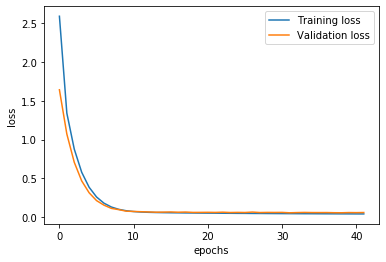

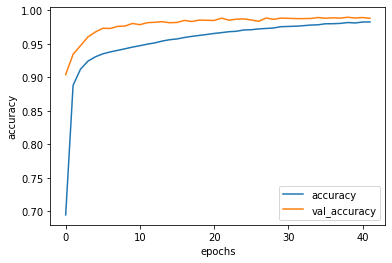

In [11]:
loss = history.history['loss'].copy()
val_loss= history.history['val_loss'].copy()
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['Training loss','Validation loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()
accuracy = history.history['accuracy'].copy()
val_accuracy = history.history['val_accuracy'].copy()
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.legend(['accuracy','val_accuracy'])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [12]:
test_x1[:1,0].shape

(1, 28, 28, 1)

In [13]:
pred1 = model.predict([test_x1[:,0],test_x1[:,1]])
pred2 = model.predict([test_x2[:,0],test_x2[:,1]])
pred3 = model.predict([test_x3[:,0],test_x3[:,1]])

In [14]:
te_acc1 = equation.compute_accuracy(test_y1, pred1)
te_acc2 = equation.compute_accuracy(test_y2, pred2)
te_acc3 = equation.compute_accuracy(test_y3, pred3)
print('* Accuracy on test1 set: %0.2f%%' % (100 * te_acc1))
print('* Accuracy on test2 set: %0.2f%%' % (100 * te_acc2))
print('* Accuracy on test3 set: %0.2f%%' % (100 * te_acc3))

* Accuracy on test1 set: 96.33%
* Accuracy on test2 set: 70.21%
* Accuracy on test3 set: 83.35%


1


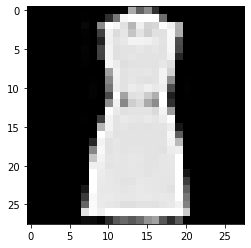

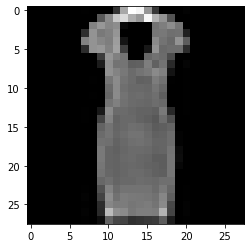

In [15]:
index = 22
print(test_y2[index])
plt.imshow(np.reshape(test_x2[index,0],(28,28))*255,cmap = 'gray')
plt.show()
plt.imshow(np.reshape(test_x2[index,1],(28,28))*255,cmap = 'gray')
plt.show()

In [ ]:
model.save('./Data/model4_m1.h5')